# Group Member :
- Raymond Lu, 87784195
- Maya Boyd, 21038542
- Fridaus Rukundo, 80351802
- Carlton Subrata, 93098606

# Introduction

**Background Information**

Video games have evolved into a central form of entertainment in today's society, capturing the interest of people across all age groups. As a result, understanding player behavior within video games has become an important topic for research (Muriel & Crawford, 2018).
    
One such project, led by Frank Wood and a research group at the University of British Columbia (UBC), aims to gather data on how individuals engage with the popular video game Minecraft. To do this, the research group has set up a Minecraft server where they can track player activity in real time.
    
The goal of this project is to provide stakeholders with valuable insights into player behavior, server usage patterns, and resource allocation. By analyzing the behavior of players on the server, the research team hopes to make informed decisions on recruiting strategies and server management. The data collected from this server is rich in detail and reflects actual player activity, making it a valuable resource for answering key questions about player engagement and behavior.

**Question**

The *broad* question we chose to focus on is: *“We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.”*

The *specific* question we chose to focus on is: *"Whether age can be a predictor for the total hours an Amateur player can contribute. Therefore, we will use the age and total hours played in the players.csv dataset for this prediction."*

**Dataset**

The dataset we are using consists of two files, players.csv and sessions.csv.

For this project, we will focus solely on the players.csv file, which contains general information about each player.

The *players.csv* contains 196 players and 7 variables, which are as follows:

| Variable     | Characteristics | Meaning |
|--------------|-----------------|---------|
| experience |Categorical/chr | indicates the player's experience level|
| subscribe| Boolean/lgl  |  indicates whether the player has subscribed to a game-related newsletter|
| hashedEmail  | String/chr  | A hashed version of the player's email address for identification|
| played_hours | Numerical/dbl | represents the number of hours a player has spent on the server|
| name | String/chr | represents the player's name|
| gender| String/chr | Indicates the gender of the player|
| age | Numerical/dbl | represents the age of the player|


**Issues with the dataset**
1. There are missing values in the age column.
2. Some players have logged an extremely high number of hours, which skews the data.
3. Several players have zero played hours.
4. The size of the dataset is limited to 196 unique participants.
5. Experience labels are vague, with no clear indication of what metric or criteria are being used to determine label value.
6. The dataset largely consisted of males around 20 years old.
7. Lack of data of players who plays moderate amount of time.

# Method

**Main Question:**
How effective and accurate age (years) is at predicting the hours an amateur participant will contribute to the study.

In order to answer our main question, *KKN regression* is the ideal choice since it involves predicting a numerical value (hours played) for new participants using the currently available data.

**Assumptions:**
1. The data set is representative of future players and participants.
2. (KNN) Amateur players with similar ages will contribute similar playing hours.
3. Predictions and prediction accuracy from models are abstractable beyond just amateur players.
4. (Linear Regression) Linear relationship between variables.

**Limitations:**
1. Only using one predictor variable means that we are not considering other factors.
2. The data set provided is very limited which may cause the accuracy of the model.
3. Since distance is used for KNN Regresion there is a need to standardized the data.

# Analysis

**Importing Libraries:**

In [20]:
#Importing Library
library(tidyverse)
library(tidymodels)

**Reading and Wrangling:**

Using the read_csv function provided through the tidyverse library, we loaded the players.csv file into a dataframe object, accessed through a relative path to the project’s associated data folder. Subsequently, the dataset had observations with missing values omitted, and was filtered for players tagged with an “Amateur” level of experience, resulting in an object with 63 observations and 7 variables. 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_age,med_age,sd_hours
<dbl>,<dbl>,<dbl>
20.25397,19,5.083078


mean_hours,med_hours,sd_hours
<dbl>,<dbl>,<dbl>
6.01746,0.1,21.98721


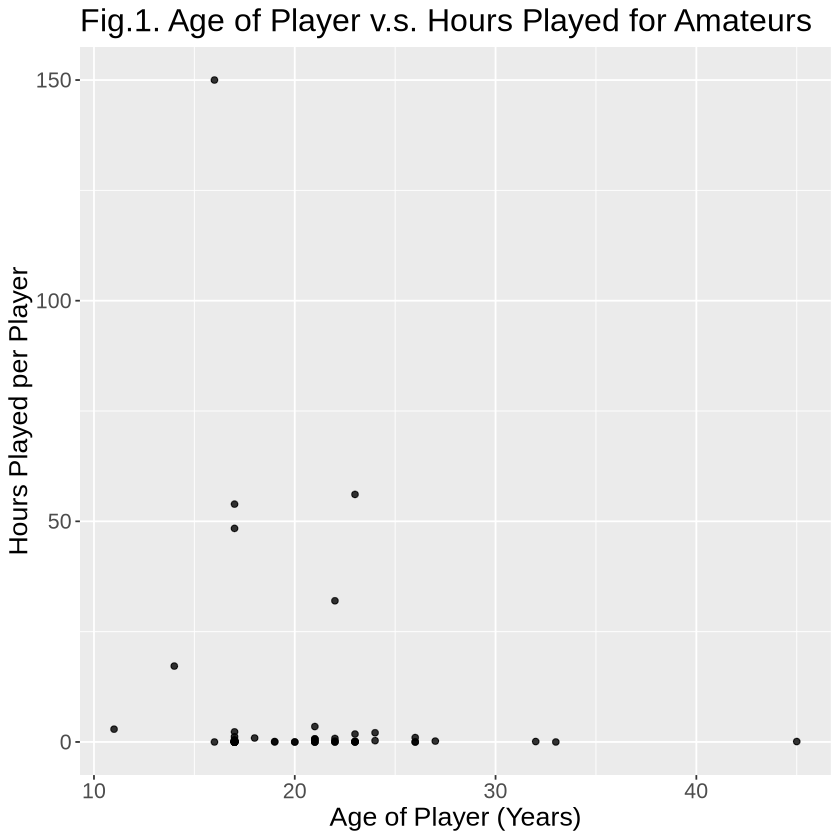

In [21]:
# loading player data into players df
# loading player data into players df
players <- read_csv("data/players.csv")

# Filtering data for amateur players, ommiting missing data
filtered_players <- players |>
filter(experience == "Amateur") |>
na.omit()

filtered_players <- players |>
filter(experience == "Amateur") |>
na.omit()

filtered_plot <- filtered_players |>
ggplot(aes(x = Age, y = played_hours)) +
geom_point(alpha = 0.8) +
labs(x = "Age of Player (Years)", y = "Hours Played per Player") + 
theme(text = element_text(size = 16)) +
ggtitle("Fig.1. Age of Player v.s. Hours Played for Amateurs")
filtered_plot


# filtered_players
summary_hours <- filtered_players |>
summarize(

    mean_hours = mean(played_hours),
    med_hours = median(played_hours),
    sd_hours = sd(played_hours)   
)

summary_age <- filtered_players |>
summarize(
    mean_age = mean(Age),
    med_age =  median(Age),
    sd_hours = sd(Age)
)

summary_age
summary_hours

A scatter plot visualizing the relationship between the Age and played_hours variables was created. Alpha was set to 0.8 for visual clarity, given light clustering of data. The graph did not show a noticeable relationship between the two variables, and the linearity of the relationship was determined to be insufficient for linear regression to be applied. K-Nearest Neighbor regression was selected instead. 

**KNN Regression:**

An initial split was conducted, separating our working data into training and testing subsets. The split was conducted using the initial_split function, with a 75-25 proportion (training to testing), with played_hours as the strata variable. A larger proportion was selected to compensate for the limited size of our working dataset.

In [22]:
# setting seed for project
set.seed(1)

# creating split & training/testing sets
player_split <- initial_split(filtered_players, strata = played_hours, prop = 0.75)
player_training <- training(player_split)
player_testing <- testing(player_split)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 3 breaks instead.”


A recipe was initialized for the generated training subset, specifying played_hours as the response variable, and Age as the predictor variable. Since KNN Regression relies on distance metrics, steps were added to standardize the two variables, ensuring their respective scales were equitably comparable. 

In [23]:
# creating workflow 

# recipe
knn_recipe <- recipe(played_hours ~ Age, data = filtered_players) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

A preprocessing model specification was created using the nearest_neighbor function. The weight function for the model was set to “rectangular ” to give equal weight to each neighbor, and regression was set as the specified problem mode. The computational engine for the model was selected to be “kknn”. The number of neighbors for the model was set to the tune function, to facilitate the use of Cross-validation for parameter value selection.

In [24]:
# model object
knn_spec <- nearest_neighbor(weight_func = "rectangular", mode = "regression", engine = "kknn", neighbors = tune()) 

**Cross-Validation**

5 validation sets were generated using the vfold_cv function to select the most appropriate K value for our model. A grid of values representing potential K values ranging from 1 to 32 was also created. 

In [25]:
# Cross-Validation

# creating validation sets
player_vfold <- vfold_cv(player_training, v = 5, strata = played_hours)
grid_vals <- tibble(neighbors = seq(1, 32, 1))

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 2 breaks instead.”


In [26]:
# creating tuning workflow
player_workflow <- workflow() |>
add_recipe(knn_recipe) |>
add_model(knn_spec)

player_results <- player_workflow |>
tune_grid(resamples = player_vfold, grid = grid_vals) |>
collect_metrics() |>
filter(.metric == "rmse")

player_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,26.12369,5,9.470785,Preprocessor1_Model01
2,rmse,standard,23.96365,5,7.969523,Preprocessor1_Model02
3,rmse,standard,21.95728,5,7.327325,Preprocessor1_Model03
4,rmse,standard,20.33274,5,7.644228,Preprocessor1_Model04
5,rmse,standard,19.42321,5,7.858820,Preprocessor1_Model05
6,rmse,standard,18.84286,5,8.017513,Preprocessor1_Model06
7,rmse,standard,18.61693,5,8.050866,Preprocessor1_Model07
8,rmse,standard,18.36691,5,8.132512,Preprocessor1_Model08
9,rmse,standard,18.20228,5,8.177003,Preprocessor1_Model09


Using K = 13, we retrained our model specification, keeping all other associated parameters the same.  We fit the model to our training subset in an updated workflow, predicted values for our response variable using our testing subset, and binded the predicted values to the subset’s data frame to facilitate comparison. Accuracy of the model was computed using the metrics() function, and results were filtered to isolate the estimated RMSPE from our model. 

A grid of values was created to represent the range of possible ages within our working data, ranging from 11 to 45. Our model was used to find the played hours for all ages in the given range, giving a continuous set of predicted values. This set was visualized as a line plot, showing the trend between age of participants and predicted values from our model. This was overlaid on the previously created scatter plot depicting age against played hours. For visual clarity, the line plot was colored blue, and the alpha for the scatter plot was set to 0.4. 

# Model:

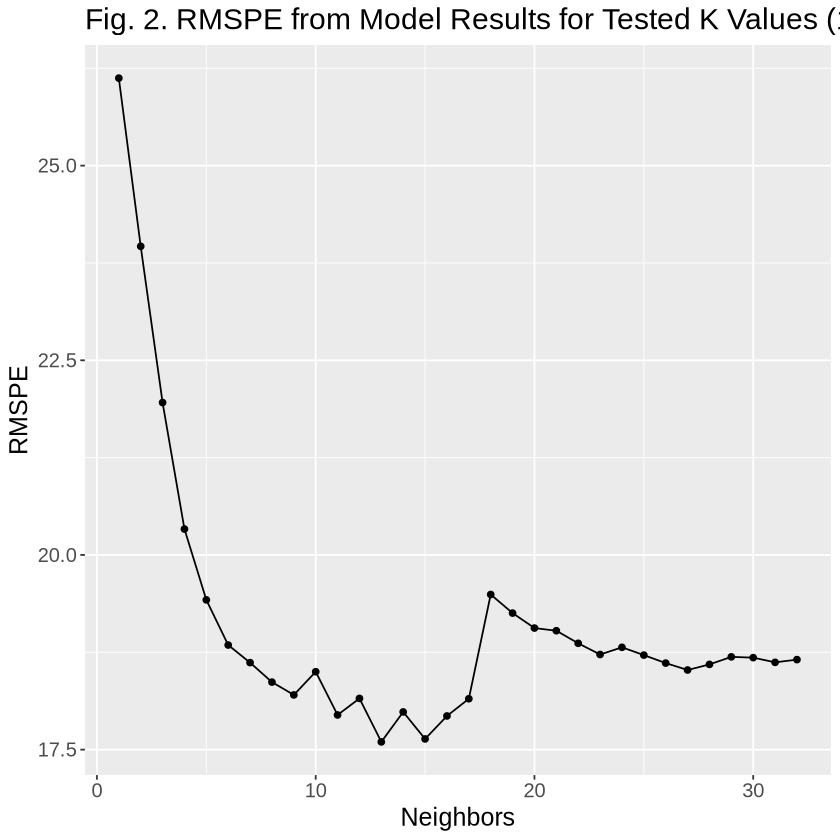

In [28]:
# plot showing mean rmspe vs K value
result_plot <- player_results |>
ggplot(aes(x = neighbors, y = mean)) + 
geom_line() +
geom_point() + 
labs(x = "Neighbors", y = "RMSPE") + 
theme(text = element_text(size = 15)) + 
ggtitle("Fig. 2. RMSPE from Model Results for Tested K Values (1 - 32)") 

result_plot

A workflow was generated using the created recipe and preprocessing model specification, and was subsequently used to fit the model to our validation sets using all K values specified in our grid. The results from these iterations were collected and filtered for observations related to RMSPE, and then further filtered to select the observation with the minimum mean RMSPE value.  Additionally, a line plot was generated, depicting the trend of mean RMSPE relative to the range of K values tested.  Points were added to quantify specific K values. From the filtered minimum result, and through visual verification, K = 13 was selected as the optimal number of neighbors to minimize model RMSPE.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,13.3941


.pred,Age
<dbl>,<dbl>
13.13076923,11
13.13076923,12
13.13076923,13
12.90769231,14
12.90769231,15
11.58461538,16
0.04615385,17
0.12307692,18
0.10769231,19


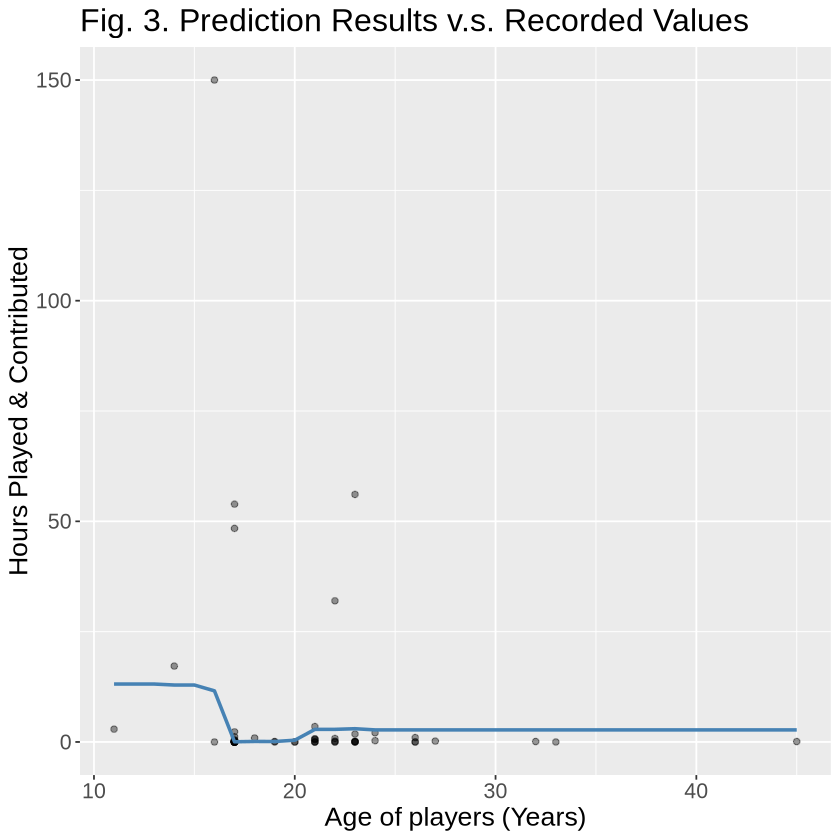

In [29]:
best_k <- player_results |>
filter(mean == min(mean)) |>
select(neighbors) |>
pull()

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k, engine = "kknn", mode = "regression")

player_fit <- workflow() |>
add_model(player_spec) |>
add_recipe(knn_recipe) |>
fit(data = player_training)

player_summary <- player_fit |>
predict(player_testing) |>
bind_cols(player_testing) |>
metrics(truth = played_hours, estimate = .pred) |>
filter(.metric == 'rmse')

player_summary

pred_grid <- tibble(

    Age =  seq(

        from = filtered_players |> select(Age) |> min(),
        to = filtered_players |> select(Age) |> max(),
        by = 1
        
    )
)

player_preds <- player_fit |>
predict(pred_grid) |>
bind_cols(pred_grid)

player_preds

player_plot <- ggplot(filtered_players, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = player_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Age of players (Years)") +
  ylab("Hours Played & Contributed") +
  theme(text = element_text(size = 16)) +
  ggtitle("Fig. 3. Prediction Results v.s. Recorded Values")

player_plot
     

**Result:**
Our final model’s test error as assessed by RMSPE was 13.454 hours with the best k value of 13. The RMPSE is quite high, especially the fact that the average hours played for amateur players is only 5.9 hours. From the RMSPE graph, we can see that our model struggles to accurately predict lower amounts of playtime.

# Discussion:

From the model which we created doing this investigation, we were able to conclude that age cannot accurately predict the number of hours which a player of the Amateur skill level contributes to the study. We can extend this to say that that age is not a predictor of Minecraft play time. Our model was extremely inaccurate with an RMSPE of about 13.5 hours. This means that, on average, the model we created predicts a number of playing hours within 13.5 hours of the actual number of hours played. Given that the average number of hours played is 5.9, this is a very large measure of error.
    
Through visualizations, we discovered that a high amount of Amateur players recorded zero hours. We also discovered that there were a few outliers with a very high number of recorded playing hours. When combining these two observations we discovered that the data was very unevenly distributed. This skewed our model. Datasets with extreme outliers are not great for making predictive models off of. 
    
We did not expect the data to be as uneven as it was. There were many more players with zero hours than we expected. This makes creating a predictive model difficult. We found it interesting that so many people participating in a study do not appear to be contributing data. Additionally, we found a few people who played for many hours (>100) but not many who played for moderate amounts of time. Critically thinking, we can assume that this sample is not representative of all people at an Amateur playing level in the population. We expected this group to have many more people who play a more moderate amount of time. Before visualizing hours played in respect to age, we assumed that there would be a similar amount of hours for most players at the same skill level, or that there would be a trend with age. We did not expect to have most of our data be at extreemes (0 or very high).
    
Our findings were not only not significant, but showed no correlation whatsoever between age and playing hours in Amateur players. We found many players with no hours recorded. The data and relationship (or rather lack there of) left us with questions which could be used for very interesting follow up studies. We would be eager to know how a person gets their “experience” classification. Many of the amateurs we looked at had no playing hours, so we can assume it was not based on that. However, this question may require more information that the datasets we were given can provide, such as more details of how the study is running. More questions can be asked about age, and if it is a predictor for any other variable. This could be vital for the stakeholders to fully investigate, as determining which age groups they should be marketing to and in what ways could be beneficial. Perhaps there is a relationship between age and experience, or time of day played. 
    
To conclude, we were not able to get any relationship out of our investigation which the shareholders may find useful. Our model does not look to be able to accurately predict hours of play time when given the age of an Amateur player. However, this investigation highlihgted the high number of Amateur individuals who do not appear to be contributing data, and this could be valuable information for not only the stakeholders, but the people conducting the study.

# Reference 
Muriel, D., Crawford, G. (2018, March 13). *Video Games as Culture* (pp.208). Routledge. 

https://doi.org/10.4324/9781315622743
